In [1]:
import os
import re
import sys
import itertools
from copy import deepcopy
from datetime import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import StanfordNERTagger
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import enchant

from utils import pos_translator, remove_numbers, is_article_quote, \
                  is_copy_paste, ordinal_text2int, text2int

In [2]:
path_to_stanford_ner = "/Users/gogrean/code/stanford-ner-2014-06-16"

os.environ['STANFORD_MODELS'] = path_to_stanford_ner + "/classifiers"
os.environ['CLASSPATH'] = path_to_stanford_ner
st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz')

wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()
d = enchant.Dict('en_US')

In [3]:
root_dir = "/Users/gogrean/Documents/kaggle/off_kaggle_ds/elect2016/"

df_trump = pd.read_csv(root_dir + "data/trumps_tweets.csv")
df_clinton = pd.read_csv(root_dir + "data/clintons_tweets.csv")

I flag article quotes and copy-pasted tweets, and exclude them from the analysis. Trump, when tweeting from Android, often retweets by copy-pasting another user's tweet. These tweets are excluded from the analysis in their entirety, even if the retweet is followed by some of Trump's own words. The same thinking is applied to tweets that contain article quotes&mdash;even if part of the tweet contains one of the candidates' own words, the full tweet is excluded. Typical Twitter retweets are excluded as well.

In [4]:
for i, text in enumerate(df_trump.text):
    df_trump.at[i, 'copy_paste'] = is_copy_paste(text)
    df_trump.at[i, 'article_quote'] = is_article_quote(text)

for i, text in enumerate(df_clinton.text):
    df_clinton.at[i, 'copy_paste'] = is_copy_paste(text)
    df_clinton.at[i, 'article_quote'] = is_article_quote(text)

filtered_tweets_trump = df_trump[(df_trump.copy_paste == False) & (df_trump.article_quote == False) &
                                 (df_trump.is_retweet == False)]
filtered_tweets_clinton = df_clinton[(df_clinton.copy_paste == False) & (df_clinton.article_quote == False) & 
                                     (df_clinton.is_retweet == False)]

Next I tokenize the tweets. Some of the tweets are not fully tokenized because words are separated by a dash or forward slash. `nltk` can't seem to deal with these, so I'm fixing the tweets by hand. Looping over the tweets, I tokenize the text, tag the words using the Stanford NER Tagger, and remove hashtags, user mentions, links, stopwords, 1-2 character words, punctuation marks, person names, and locations. I also exclude words that have forward slashes and formatted quotation marks in them. 

Because names that are written in all caps are not always recognized as names, I format every all-caps string using the `title()` method and re-tag the word. If the re-formatted word is still not recongized as a person name or location, I keep the word in the tweet.

Clinton's tweets are sometimes signed with "-H" or "[-]Hillary". I remove the signature from these tweets. Also, some of Clinton's tweets are written in Spanish. Only tweets written in English are included in the analysis.

The function `tag_corpus` takes a `method` argument that can be either `lemmatization` or `stemming` (default). This determines how the morphological analysis is done.

In [5]:
punctuation_marks = ["!", ".", "?", ";", ":", "?!", ")", "(", "'", 
                     '"', ",", "-", "...", "…", "``", "`", "’", "“", 
                     '#', "&", "@", "—", "–", "”", "‘"]
eos_punctuation_marks = [".", "!", "?"]

def make_corpus(df):
    n_chars, n_tokens = 0, 0
    tokenized_corpus = []
    flagged_indices = []
    start_of_tweet_indices = [0]
    url_regex = re.compile(r'https?:\/\/[a-zA-z0-9\/#%\.]+')
    for tweet, hashtags, mentions in zip(df.text, df.hashtags, df.user_mentions):
        n_chars += len(tweet)
        hashtag_list, mention_list = [], []
        if hashtags is not np.nan:
            hashtag_list = [h for h in hashtags.lower().split(", ")]
        if mentions is not np.nan:
            mention_list = [m for m in mentions.lower().split(", ")]
        tweet = re.sub(url_regex, '', tweet)
        tokens = word_tokenize(tweet)
        for dash in ["—", "–", "/"]:
            offset = 0
            split_words = [(i, word) for i, word in enumerate(tokens) if dash in word]
            for i, word in split_words:
                i += offset
                subwords = [subword for subword in word.split(dash) if subword != '']
                tokens[i:i+1] = subwords
                offset += (len(subwords) - 1)

        start_of_tweet_indices.append(start_of_tweet_indices[-1] + len(tokens))
        this_tweet_flagged_indices = [n_tokens + i 
                                      for i, w in enumerate(tokens) 
                                      if w.lower() in hashtag_list or w.lower() in mention_list]
        n_tokens += len(tokens)
        tokenized_corpus.extend(tokens)
        flagged_indices += this_tweet_flagged_indices
    return n_chars, flagged_indices, start_of_tweet_indices, tokenized_corpus

def tag_corpus(tokenized_corpus, start_of_tweet_indices, flagged_indices=[], method='stemming'):
    hillary = ['hillary', '-hillary', '-h', "–hillary", "—hillary"]
    stopset = stopwords.words('english')
    forbidden = ["http", "//", "amp", "una", "gun", "los"] + punctuation_marks
    n_incomplete_sentences = 0
    incomplete_sentences = {}
    tags = st.tag(tokenized_corpus)
    modified_corpus = False
    for i, w in enumerate(tags):
        if w[0].isupper() and w[1] == 'O':
            tokenized_corpus[i] = w[0].title()
            modified_corpus = True
    if modified_corpus:
        tags = st.tag(tokenized_corpus)
    pos_tags = nltk.pos_tag(tokenized_corpus)
    for idx in start_of_tweet_indices[1:]:
        n_words_in_sentence = 0
        parts_of_speech = []
        while pos_tags[idx-1][1] == '.' or idx-1 in flagged_indices \
        or pos_tags[idx-1][0].lower() in hillary or "//" in pos_tags[idx-1][0]:
            idx -= 1
            if idx in flagged_indices:
                if pos_tags[idx] not in eos_punctuation_marks:
                    continue
                idx -= 1
            if "//" in pos_tags[idx][0]:
                idx -= 2
        for k, pos_tag in enumerate(reversed(pos_tags[:idx])):
            if n_words_in_sentence > 3:
                break
            if pos_tag[1] != '.':
                if idx-k-1 in flagged_indices:
                    break
                if pos_translator(pos_tag[1]) == 'v' and pos_tag[1] != 'VBG':
                    break
                if any(c for c in pos_tag[0] if c.isnumeric() or c == '='):
                    break
                if not d.check(pos_tag[0].lower()):
                    break
                n_words_in_sentence += 1
                parts_of_speech.append(pos_tag)
            else:
                if any(j for j in parts_of_speech 
                       if (pos_translator(j[1]) == 'a')):
                    n_incomplete_sentences += 1
                    fragment = " ".join([p[0].upper() for p in reversed(parts_of_speech)])
                    for p in parts_of_speech:
                        if pos_translator(p[1]) == 'a':
                            if p[0].upper() in incomplete_sentences:
                                if fragment in incomplete_sentences[p[0].upper()]:
                                    incomplete_sentences[p[0].upper()][fragment] += 1
                                else:
                                    incomplete_sentences[p[0].upper()][fragment] = 1
                            else:
                                incomplete_sentences[p[0].upper()] = {}
                                incomplete_sentences[p[0].upper()][fragment] = 1
                break
                
    for index in reversed(flagged_indices):
        del tags[index]
        del pos_tags[index]
                
    tags = remove_numbers(tags)
    pos_tags = remove_numbers(pos_tags)
    if method is 'lemmatization':
        words_in_corpus = [wordnet_lemmatizer.lemmatize(w[0].lower(), pos=pos_translator(p[1])) 
                           for w, p in zip(tags, pos_tags) 
                           if w[1] == 'O' and w[0].lower() not in stopset and
                           len(w[0]) > 2 and not any(c.isdigit() for c in w[0]) and
                           not any(f in w[0] for f in forbidden) and 
                           w[0].lower() not in hillary]
    else:
        words_in_corpus = [porter_stemmer.stem(w[0].lower()) 
                           for w in tags
                           if w[1] == 'O' and w[0].lower() not in stopset and
                           len(w[0]) > 2 and not any(c.isdigit() for c in w[0]) and
                           not any(f in w[0] for f in forbidden) and
                           w[0].lower() not in hillary]
    adjectives = [wordnet_lemmatizer.lemmatize(w[0].lower(), pos=pos_translator(p[1])) 
                  for w, p in zip(tags, pos_tags)
                  if w[1] == 'O' and w[0].lower() not in stopset and
                  len(w[0]) > 2 and not any(c.isdigit() for c in w[0]) and
                  not any(f in w[0] for f in forbidden) and
                  (pos_translator(p[1]) == 'a') and
                  w[0].lower() not in hillary]
    adverbs = [wordnet_lemmatizer.lemmatize(w[0].lower(), pos=pos_translator(p[1])) 
               for w, p in zip(tags, pos_tags)
               if w[1] == 'O' and w[0].lower() not in stopset and
               len(w[0]) > 2 and not any(c.isdigit() for c in w[0]) and
               not any(f in w[0] for f in forbidden) and
               (pos_translator(p[1]) == 'r') and
               w[0].lower() not in hillary]
    verbs = [wordnet_lemmatizer.lemmatize(w[0].lower(), pos=pos_translator(p[1]))
             for w, p in zip(tags, pos_tags)
             if w[1] == 'O' and w[0].lower() not in stopset and
             len(w[0]) > 2 and not any(c.isdigit() for c in w[0]) and
             not any(f in w[0] for f in forbidden) and
             (pos_translator(p[1]) == 'v') and 
             w[0].lower() not in hillary]
    n_words = len(words_in_corpus)
    unique_words = set(words_in_corpus)
    return n_words, unique_words, adjectives, adverbs, verbs, \
           incomplete_sentences, n_incomplete_sentences

In [6]:
n_chars_trump, flagged_indices_trump, start_of_tweet_indices_trump, corpus_trump = make_corpus(filtered_tweets_trump)
n_words_trump, voc_trump, adj_trump, adv_trump, verb_trump, \
ins_trump, n_ins_trump = tag_corpus(corpus_trump, 
                                    start_of_tweet_indices_trump,
                                    flagged_indices_trump)

n_chars_clinton, flagged_indices_clinton, start_of_tweet_indices_clinton, corpus_clinton = make_corpus(filtered_tweets_clinton)
n_words_clinton, voc_clinton, adj_clinton, adv_clinton, verb_clinton, \
ins_clinton, n_ins_clinton = tag_corpus(corpus_clinton,
                                        start_of_tweet_indices_clinton,
                                        flagged_indices_clinton)

Trump seems to have the habit of ending many of his tweets with a sentence fragment, e.g. *"Crooked Clinton annoyed me today. Sad!"* Using the output from `tag_corpus`, I look at the adjectives most common in these end-of-tweet sentence fragments and at the most common fragments in which they are used. I do this for both candidates, though, as I will show later, these fragments are significantly more common in Trump's tweets. Trump's most common adjectives in end-of-tweet sentence fragments also tend to be negative, unlike Clinton's (except when she makes fun of Trump). For example, Trump's two most common adjectives are 'dishonest' (8x) and 'sad' (7x), while Clinton's two most common are 'sad' (2x; when making fun of Trump) and 'happy' (2x); Clinton's next are 'much', 'hard' (when promoting her book *Hard Choices*), 'grateful', 'first' (all 1x).

Below I show the top six adjectives of both candidates.

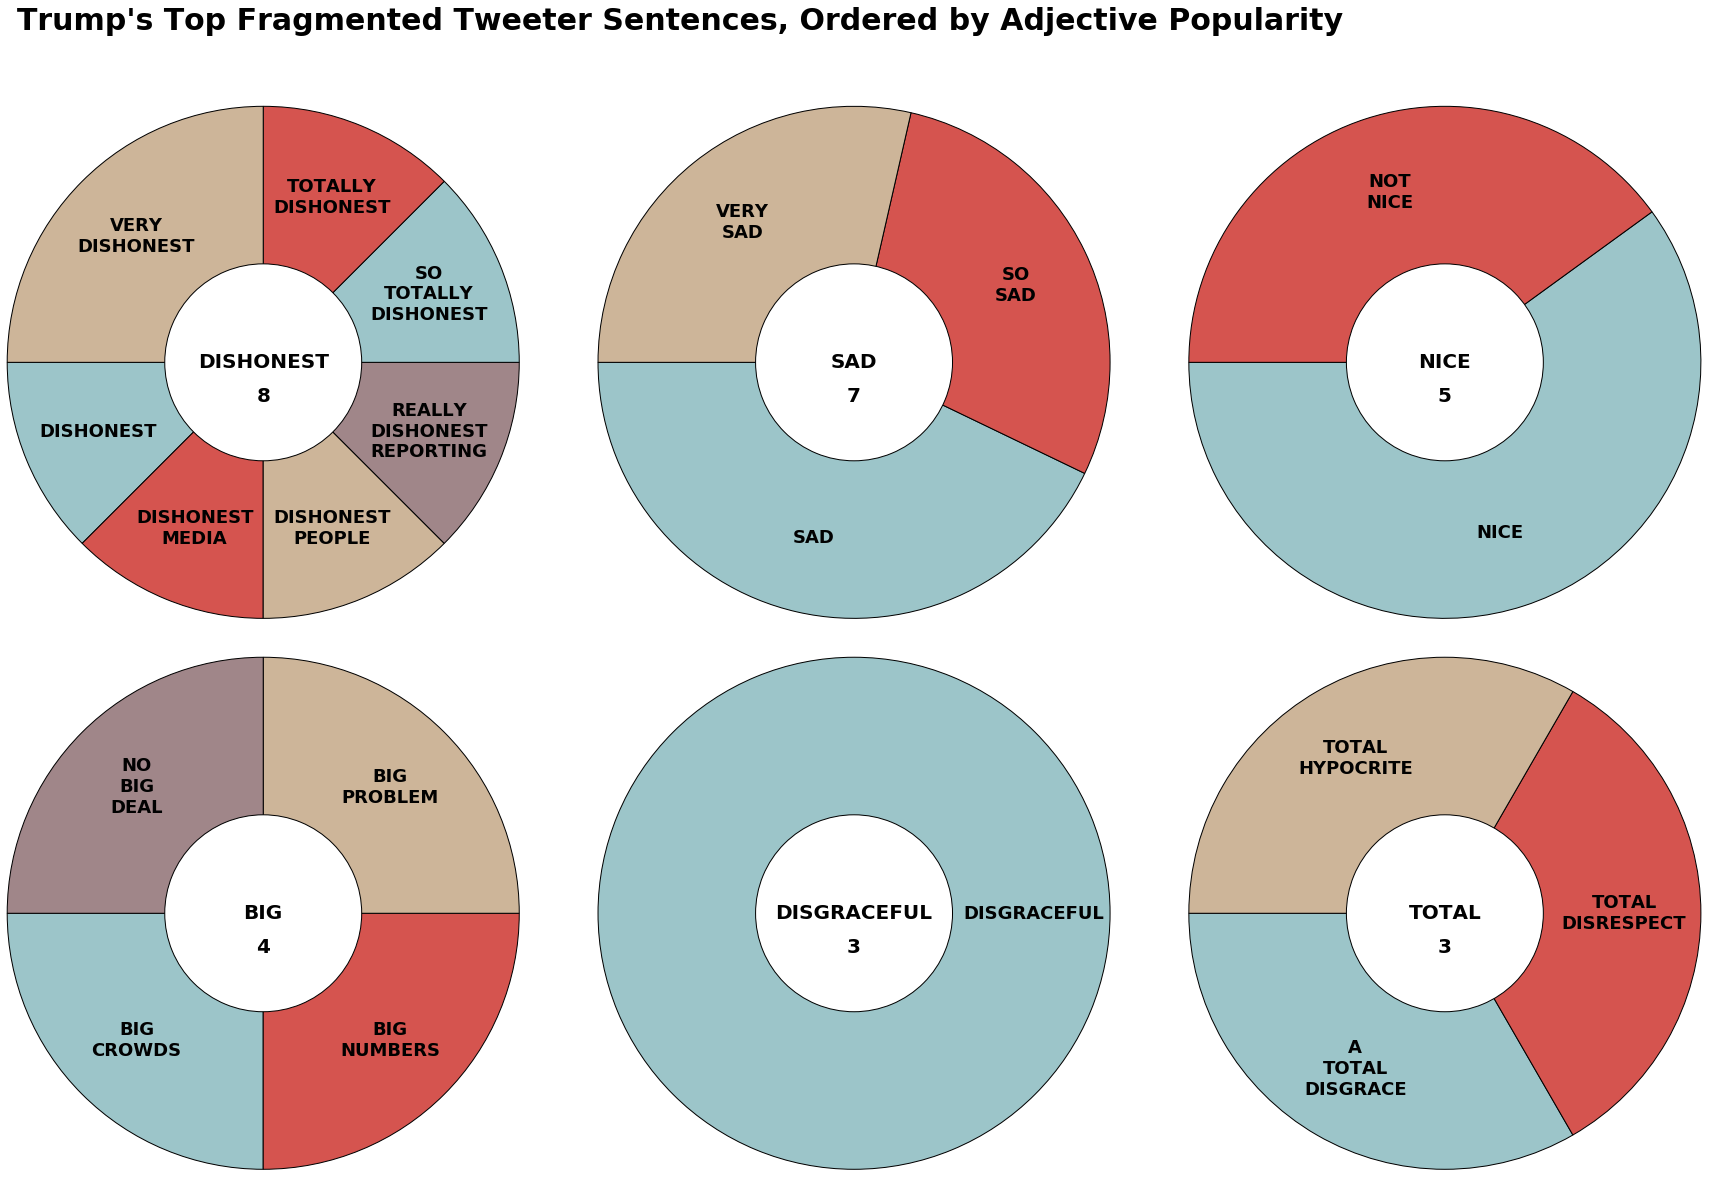

In [7]:
n_top = 6

plt.rcParams['xtick.labelsize'] = 18
fig, ax = plt.subplots(2, n_top//2, figsize=(30,20))

data_trump = pd.DataFrame.from_dict(ins_trump).fillna(value=0)
top_adj_trump = data_trump.sum(axis=0).sort_values(ascending=False)[:n_top].index
kwargs = dict(size=20, color='black', va='center', ha='center', weight='heavy')
colors_trump = ['#9CC5C9',  '#D5544F', '#CDB599', '#A08689']
for i, adj in enumerate(top_adj_trump):
    ax[i // (n_top//2), i % (n_top//2)].axis('equal')
    pie_slices = [(f, n) for (f, n) in zip(list(data_trump[adj].index), list(data_trump[adj].values)) 
                  if n > 0]
    pie_slice_values = [n for (f, n) in pie_slices]
    pie_slice_labels = ["\n".join(f.split()) for (f, n) in pie_slices]
    pie_colors = [colors_trump[i % len(colors_trump)] for i in range(len(pie_slice_values))]
    _, labels = ax[i // (n_top//2), i % (n_top//2)].pie(pie_slice_values, radius=1.3, 
                                                        labels=pie_slice_labels, labeldistance=0.7, 
                                                        textprops={'weight': 'heavy'}, 
                                                        colors=pie_colors, startangle=180)
    for label in labels:
        label.set_horizontalalignment('center')
    ax[i // (n_top//2), i % (n_top//2)].pie([1], radius=0.5, colors='white')
    ax[i // (n_top//2), i % (n_top//2)].text(0, 0, adj, wrap=True, 
               bbox=dict(boxstyle='circle', facecolor='white', edgecolor='none'),
               **kwargs)
    ax[i // (n_top//2), i % (n_top//2)].text(0, -0.17, int(sum(pie_slice_values)),
               **kwargs)
ax[0,0].set_title("Trump's Top Fragmented Tweeter Sentences, Ordered by Adjective Popularity", 
                  loc='left', fontsize=30, y=1.08, weight='heavy')
plt.subplots_adjust(hspace=-0.025)

plt.savefig(root_dir + 'figs/trumps_top_sentence_fragments.pdf')

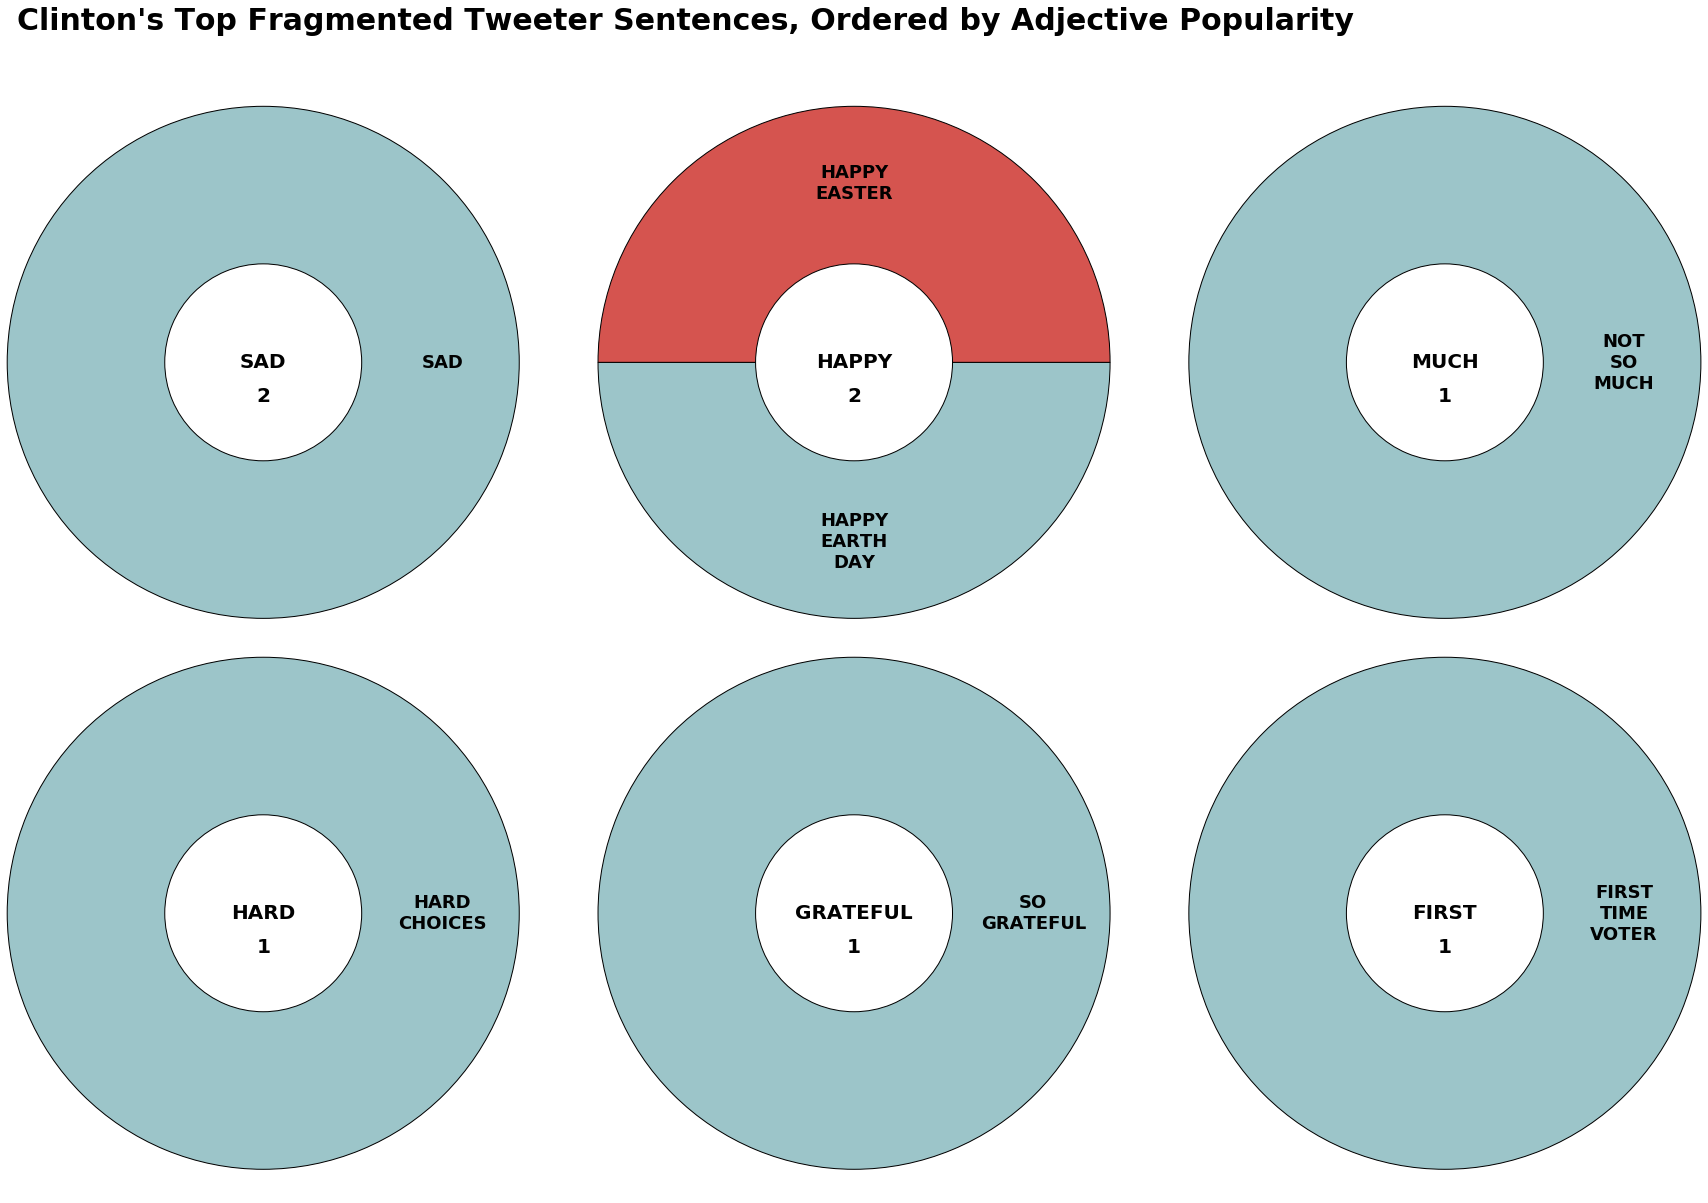

In [8]:
n_top = 6

plt.rcParams['xtick.labelsize'] = 18
fig, ax = plt.subplots(2, n_top//2, figsize=(30,20))

data_clinton = pd.DataFrame.from_dict(ins_clinton).fillna(value=0)
top_adj_clinton = data_clinton.sum(axis=0).sort_values(ascending=False)[:n_top].index
kwargs = dict(size=20, color='black', va='center', weight='heavy')
colors_clinton = ['#9CC5C9',  '#D5544F', '#CDB599', '#A08689']
for i, adj in enumerate(top_adj_clinton):
    ax[i // (n_top//2), i % (n_top//2)].axis('equal')
    pie_slices = [(f, n) for (f, n) in zip(list(data_clinton[adj].index), list(data_clinton[adj].values)) 
                  if n > 0]
    pie_slice_values = [n for (f, n) in pie_slices]
    pie_slice_labels = ["\n".join(f.split()) for (f, n) in pie_slices]
    pie_colors = [colors_clinton[i % len(colors_clinton)] for i in range(len(pie_slice_values))]
    _, labels = ax[i // (n_top//2), i % (n_top//2)].pie(pie_slice_values, radius=1.3, 
                                                        labels=pie_slice_labels, labeldistance=0.7, 
                                                        textprops={'weight': 'heavy'}, 
                                                        colors=pie_colors, startangle=180)
    for label in labels:
        label.set_horizontalalignment('center')
    ax[i // (n_top//2), i % (n_top//2)].pie([1], radius=0.5, colors='white')
    ax[i // (n_top//2), i % (n_top//2)].text(0, 0, adj, ha='center', wrap=True, 
               bbox=dict(boxstyle='circle', facecolor='white', edgecolor='none'),
               **kwargs)
    ax[i // (n_top//2), i % (n_top//2)].text(0, -0.17, int(sum(pie_slice_values)), ha='center',
               **kwargs)
ax[0,0].set_title("Clinton's Top Fragmented Tweeter Sentences, Ordered by Adjective Popularity", 
                  loc='left', fontsize=30, y=1.08, weight='heavy')
plt.subplots_adjust(hspace=-0.025)

plt.savefig(root_dir + 'figs/clintons_top_sentence_fragments.pdf')

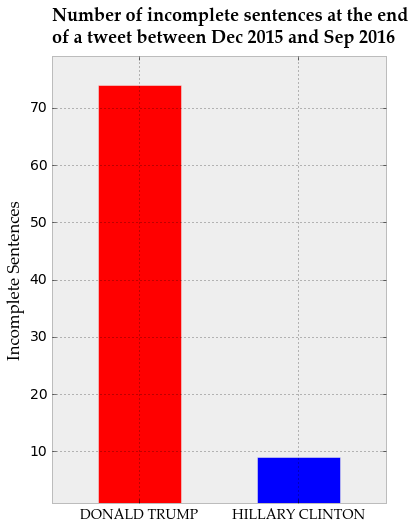

In [9]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['xtick.labelsize'] = 14
pfont = {'fontname': 'Palatino Linotype'}

plt.style.use('bmh')
fig, ax = plt.subplots(1, figsize=(6,8))

bar_pos = [0.31, 0.69]
bar_width = 0.2

ax.bar(bar_pos, [n_ins_trump, n_ins_clinton], width=0.2, color=['red', 'blue'])
ax.set_xticks([pos + bar_width/2 for pos in bar_pos])
ax.set_xticklabels(["DONALD TRUMP", "HILLARY CLINTON"], **pfont)
ax.set_title("Number of incomplete sentences at the end\nof a tweet between Dec 2015 and Sep 2016", 
                loc='left', y=1.02, fontsize=18, weight='bold', **pfont)
ax.set_ylabel('Incomplete Sentences', **pfont)
ax.set_ylim([1,79])
ax.set_xlim([0.2,1.0])

fig.savefig(root_dir + 'figs/n_incomplete_sentences.pdf')

At a PyLadies meetup, A. Widiger suggested that Trump probably uses more adjectives and less verbs than Clinton, making his tweets convey more of an emotional reaction than Clinton's. Below I plot the fraction of verbs and adjectives (and adjectives+adverbs) in Trump's and Clinton's tweets.

In [10]:
f_adj_trump = len(adj_trump) / n_words_trump
f_adv_trump = len(adv_trump) / n_words_trump
f_verb_trump = len(verb_trump) / n_words_trump

f_adj_clinton = len(adj_clinton) / n_words_clinton
f_adv_clinton = len(adv_clinton) / n_words_clinton
f_verb_clinton = len(verb_clinton) / n_words_clinton

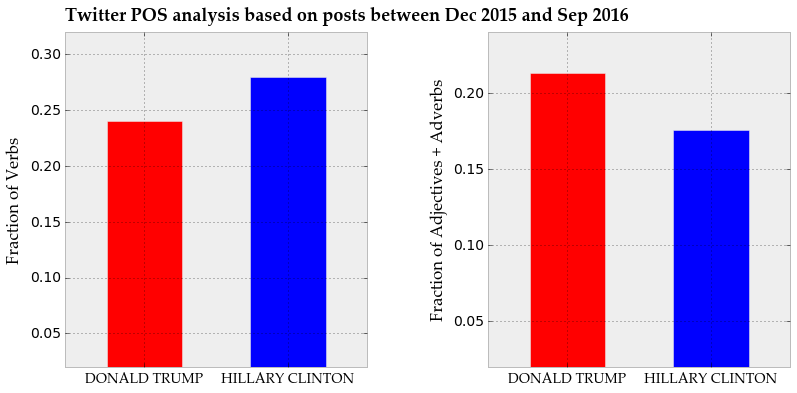

In [11]:
plt.rcParams.update({'font.size': 14})
pfont = {'fontname': 'Palatino Linotype'}

plt.style.use('bmh')
fig, ax = plt.subplots(1, 2, figsize=(13,6))

bar_pos = [0.31, 0.69]
bar_width = 0.2

ax[0].bar(bar_pos, [f_verb_trump, f_verb_clinton], width=0.2, color=['red', 'blue'])
ax[0].set_xticks([pos + bar_width/2 for pos in bar_pos])
ax[0].set_xticklabels(["DONALD TRUMP", "HILLARY CLINTON"], **pfont)
ax[0].set_title("Twitter POS analysis based on posts between Dec 2015 and Sep 2016", 
                loc='left', y=1.02, fontsize=18, weight='bold', **pfont)
ax[0].set_ylabel('Fraction of Verbs', **pfont)
ax[0].set_ylim([0.02,0.32])
ax[0].set_xlim([0.2,1.0])

ax[1].bar(bar_pos, [f_adj_trump + f_adv_trump, f_adj_clinton + f_adv_clinton], 
          width=0.2, color=['red', 'blue'])
ax[1].set_xticks([pos + bar_width/2 for pos in bar_pos])
ax[1].set_xticklabels(["DONALD TRUMP", "HILLARY CLINTON"], **pfont)
ax[1].set_ylabel('Fraction of Adjectives + Adverbs', **pfont)
ax[1].set_ylim([0.02, 0.24])
ax[1].set_xlim([0.2,1.0])
fig.subplots_adjust(wspace=0.4)

fig.savefig(root_dir + 'figs/verbs_vs_adj_adv.pdf')

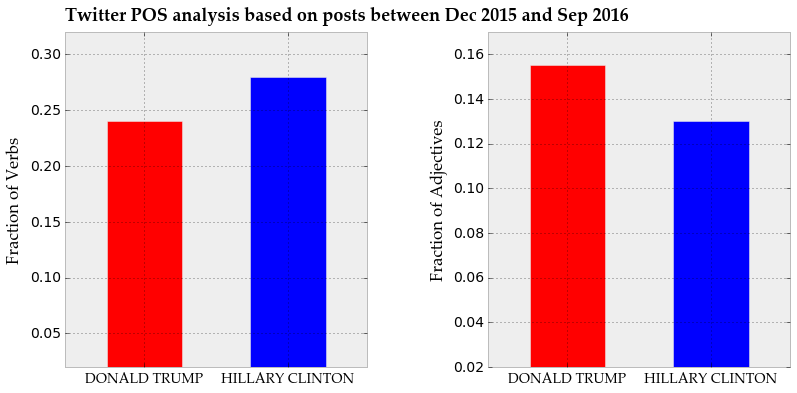

In [12]:
plt.rcParams.update({'font.size': 14})
pfont = {'fontname': 'Palatino Linotype'}

plt.style.use('bmh')
fig, ax = plt.subplots(1, 2, figsize=(13,6))

bar_pos = [0.31, 0.69]
bar_width = 0.2

ax[0].bar(bar_pos, [f_verb_trump, f_verb_clinton], width=0.2, color=['red', 'blue'])
ax[0].set_xticks([pos + bar_width/2 for pos in bar_pos])
ax[0].set_xticklabels(["DONALD TRUMP", "HILLARY CLINTON"], **pfont)
ax[0].set_title("Twitter POS analysis based on posts between Dec 2015 and Sep 2016", 
                loc='left', y=1.02, fontsize=18, weight='bold', **pfont)
ax[0].set_ylabel('Fraction of Verbs', **pfont)
ax[0].set_ylim([0.02,0.32])
ax[0].set_xlim([0.2,1.0])

ax[1].bar(bar_pos, [f_adj_trump, f_adj_clinton], 
          width=0.2, color=['red', 'blue'])
ax[1].set_xticks([pos + bar_width/2 for pos in bar_pos])
ax[1].set_xticklabels(["DONALD TRUMP", "HILLARY CLINTON"], **pfont)
ax[1].set_ylabel('Fraction of Adjectives', **pfont)
ax[1].set_ylim([0.02, 0.17])
ax[1].set_xlim([0.2,1.0])
fig.subplots_adjust(wspace=0.4)

fig.savefig(root_dir + 'figs/verbs_vs_adj.pdf')

Mostly because I was curious about creating wordclouds in Python, below I show wordclouds based on Trump's and Clinton's tweets. Because Trump's tweets from Android have a different distribution than those from iPhone, indicating that the tweets from the different devices might be posted by different people, I separate Trump's wordclouds into one based on Android tweets and one based on iPhone tweets. For both candidates, I further divide their wordclouds into two: one containing only adjectives and another containing only verbs.

In [13]:
import random
from PIL import Image
from wordcloud import WordCloud

def rep_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(%d, %d%%, %d%%)" % (0, random.randint(10, 100), random.randint(40, 60))

def dem_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(%d, %d%%, %d%%)" % (224, random.randint(40, 100), random.randint(40, 60))

android = '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>'
iphone = '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'
filtered_tweets_trump_android = df_trump[(df_trump.copy_paste == False) & (df_trump.article_quote == False) &
                                         (df_trump.is_retweet == False) & 
                                         (df_trump.source == android)]
filtered_tweets_trump_iphone = df_trump[(df_trump.copy_paste == False) & (df_trump.article_quote == False) &
                                         (df_trump.is_retweet == False) & 
                                         (df_trump.source == iphone)]

_, flagged_indices_trump_android, sot_indices_trump_android, \
    corpus_trump_android = make_corpus(filtered_tweets_trump_android)
_, voc_trump_android, adj_trump_android, \
   adv_trump_android, verb_trump_android, _, _ = tag_corpus(corpus_trump_android, 
                                                            sot_indices_trump_android,
                                                            flagged_indices_trump_android, 
                                                            method='lemmatization')
adj_wordcloud_trump_android = " ".join([adj for adj in adj_trump_android])
verb_wordcloud_trump_android = " ".join([verb for verb in verb_trump_android])

_, flagged_indices_trump_iphone, sot_indices_trump_iphone, \
    corpus_trump_iphone = make_corpus(filtered_tweets_trump_iphone)
_, voc_trump_iphone, adj_trump_iphone, \
   adv_trump_iphone, verb_trump_iphone, _, _ = tag_corpus(corpus_trump_iphone, 
                                                          sot_indices_trump_iphone,
                                                          flagged_indices_trump_iphone, 
                                                          method='lemmatization')
adj_wordcloud_trump_iphone = " ".join([adj for adj in adj_trump_iphone])
verb_wordcloud_trump_iphone = " ".join([verb for verb in verb_trump_iphone])

_, flagged_indices_clinton, sot_indices_clinton, \
    corpus_clinton_lem = make_corpus(filtered_tweets_clinton)
_, voc_clinton, adj_clinton, adv_clinton, verb_clinton, _, _ = tag_corpus(corpus_clinton_lem,
                                                                          sot_indices_clinton,
                                                                          flagged_indices_clinton, 
                                                                          method='lemmatization')
adj_wordcloud_clinton = " ".join([adj for adj in adj_clinton])
verb_wordcloud_clinton = " ".join([verb for verb in verb_clinton])

# masks taken from here:
# https://image.freepik.com/free-icon/elephant-republican-symbol_318-64492.jpg
# https://www.carstickers.com/prodimages/12960-democrat-donkey-sticker.png
republican_mask = np.array(Image.open(root_dir+'figs/republican-symbol.jpg'))
democrat_mask = np.array(Image.open(root_dir+'figs/democrat-symbol.jpg'))

# adjectives + adverbs
adj_wc_trump_android = WordCloud(background_color="white", 
                             max_words=100, min_font_size=8,
                             mask=republican_mask, width=5000, height=5000)
adj_wc_trump_android.generate(adj_wordcloud_trump_android)
adj_wc_trump_android.recolor(random_state=5, color_func=rep_color_func)

adj_wc_trump_iphone = WordCloud(background_color="white", 
                            max_words=100, min_font_size=8,
                            mask=republican_mask, width=5000, height=5000)
adj_wc_trump_iphone.generate(adj_wordcloud_trump_iphone)
adj_wc_trump_iphone.recolor(random_state=5, color_func=rep_color_func)

adj_wc_clinton = WordCloud(background_color="white", 
                       max_words=100, min_font_size=8,
                       mask=democrat_mask, width=5000, height=5000)
adj_wc_clinton.generate(adj_wordcloud_clinton)
adj_wc_clinton.recolor(random_state=5, color_func=dem_color_func)

# verbs
verb_wc_trump_android = WordCloud(background_color="white", 
                             max_words=100, min_font_size=8,
                             mask=republican_mask, width=5000, height=5000)
verb_wc_trump_android.generate(verb_wordcloud_trump_android)
verb_wc_trump_android.recolor(random_state=5, color_func=rep_color_func)

verb_wc_trump_iphone = WordCloud(background_color="white", 
                            max_words=100, min_font_size=8,
                            mask=republican_mask, width=5000, height=5000)
verb_wc_trump_iphone.generate(verb_wordcloud_trump_iphone)
verb_wc_trump_iphone.recolor(random_state=5, color_func=rep_color_func)

verb_wc_clinton = WordCloud(background_color="white", 
                       max_words=100, min_font_size=8,
                       mask=democrat_mask, width=5000, height=5000)
verb_wc_clinton.generate(verb_wordcloud_clinton)
verb_wc_clinton.recolor(random_state=5, color_func=dem_color_func)

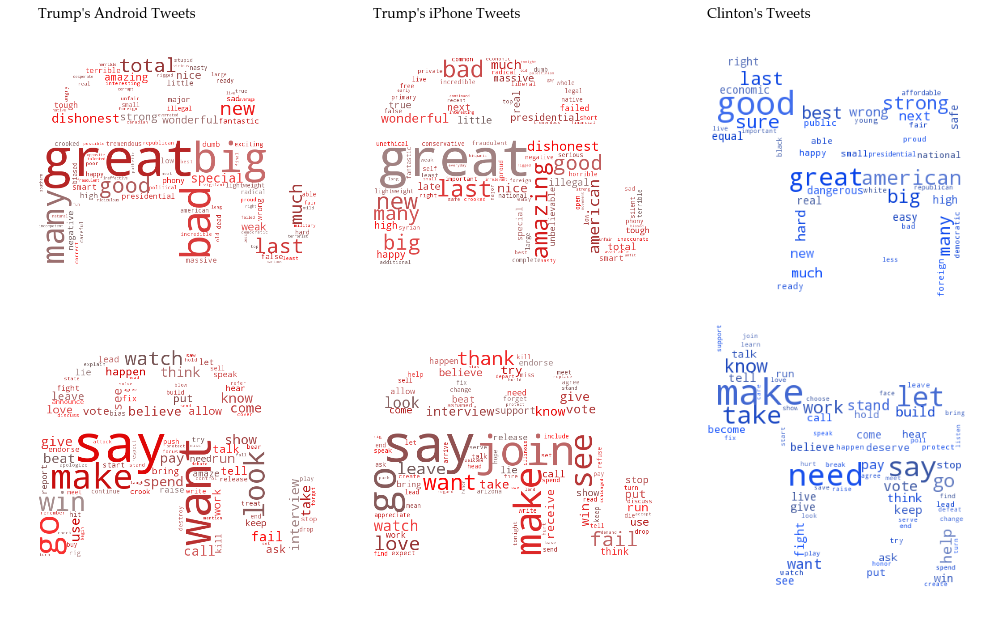

In [14]:
# do the wordcloud plotting
fig, ax = plt.subplots(2, 3, figsize=(17,14))

ax[0,0].set_title("Trump's Android Tweets", loc='left', fontsize=14, **pfont)
ax[0,0].imshow(adj_wc_trump_android)
ax[0,0].axis('off')

ax[0,1].set_title("Trump's iPhone Tweets", loc='left', fontsize=14, **pfont)
ax[0,1].imshow(adj_wc_trump_iphone)
ax[0,1].axis('off')

ax[0,2].set_title("Clinton's Tweets", loc='left', fontsize=14, **pfont)
ax[0,2].imshow(adj_wc_clinton)
ax[0,2].axis('off')

ax[1,0].imshow(verb_wc_trump_android)
ax[1,0].axis('off')

ax[1,1].imshow(verb_wc_trump_iphone)
ax[1,1].axis('off')

ax[1,2].imshow(verb_wc_clinton)
ax[1,2].axis('off')

plt.subplots_adjust(hspace=-0.4)

In [15]:
fig.savefig(root_dir + 'figs/POS_wordclouds_twitter.png', dpi=400)

Below I look at the most common adjectives and verbs in a more quantitative way. First I plot the top 20 adjectives and verbs used in Trump's and Clinton's tweets. While this provides a quick way to see the most commonly used words, it does not easily illustrate differences between Trump's and Clinton's tweets. To do that, I plot the top 20 adjectives and verbs that are mostly used by Trump relative to Clinton (and vice versa). I restrict this latter plot to Trump's Android tweets.

In [16]:
import operator 

n_top_words = 20

adj_trump_bucket_android = {}
unique_adj_trump_android = np.unique(adj_trump_android)
for a in unique_adj_trump_android:
    adj_trump_bucket_android[a] = adj_trump_android.count(a)
sorted_adj_trump_bucket_android = sorted(adj_trump_bucket_android.items(), 
                                         key=operator.itemgetter(1))[-n_top_words:]

vb_trump_bucket_android = {}
unique_vb_trump_android = np.unique(verb_trump_android)
for a in unique_vb_trump_android:
    vb_trump_bucket_android[a] = verb_trump_android.count(a)
sorted_vb_trump_bucket_android = sorted(vb_trump_bucket_android.items(), 
                                        key=operator.itemgetter(1))[-n_top_words:]

adj_trump_bucket_iphone = {}
unique_adj_trump_iphone = np.unique(adj_trump_iphone)
for a in unique_adj_trump_iphone:
    adj_trump_bucket_iphone[a] = adj_trump_iphone.count(a)
sorted_adj_trump_bucket_iphone = sorted(adj_trump_bucket_iphone.items(), 
                                        key=operator.itemgetter(1))[-n_top_words:]

vb_trump_bucket_iphone = {}
unique_vb_trump_iphone = np.unique(verb_trump_iphone)
for a in unique_vb_trump_iphone:
    vb_trump_bucket_iphone[a] = verb_trump_iphone.count(a)
sorted_vb_trump_bucket_iphone = sorted(vb_trump_bucket_iphone.items(), 
                                       key=operator.itemgetter(1))[-n_top_words:]

adj_clinton_bucket = {}
unique_adj_clinton = np.unique(adj_clinton)
for a in unique_adj_clinton:
    adj_clinton_bucket[a] = adj_clinton.count(a)
sorted_adj_clinton_bucket = sorted(adj_clinton_bucket.items(), 
                                   key=operator.itemgetter(1))[-n_top_words:]

vb_clinton_bucket = {}
unique_vb_clinton = np.unique(verb_clinton)
for a in unique_vb_clinton:
    vb_clinton_bucket[a] = verb_clinton.count(a)
sorted_vb_clinton_bucket = sorted(vb_clinton_bucket.items(), 
                                  key=operator.itemgetter(1))[-n_top_words:]

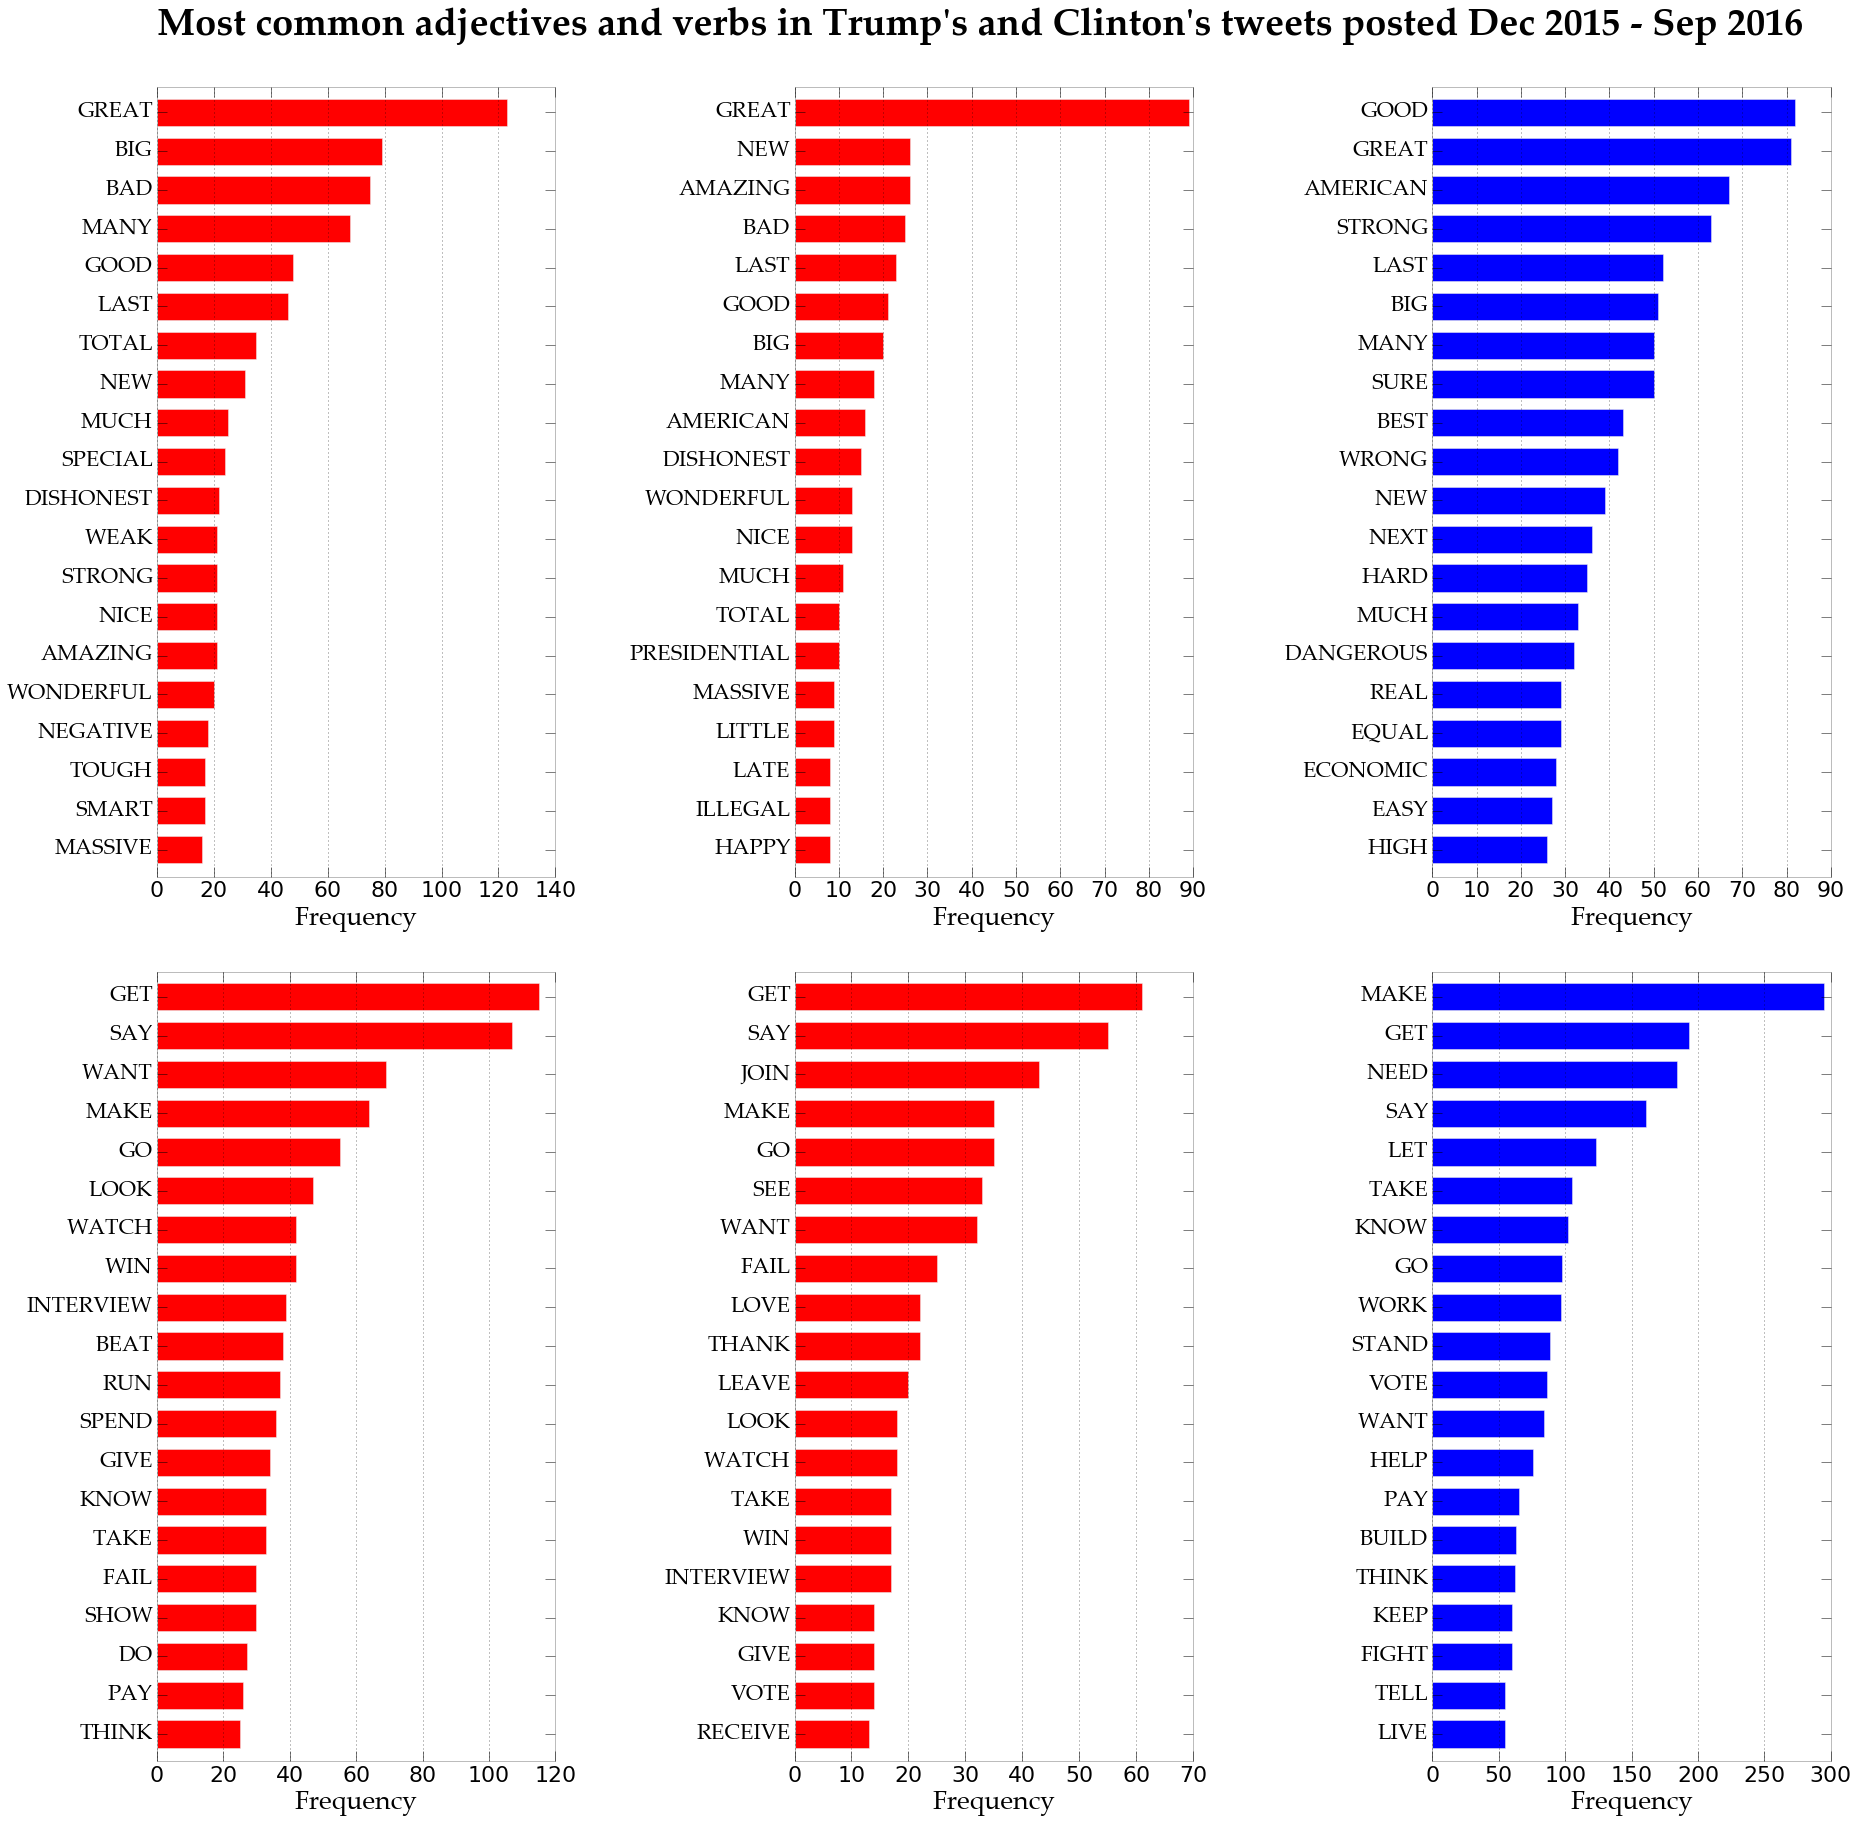

In [17]:
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'xtick.major.size': 10})
plt.rcParams.update({'ytick.major.size': 10})
pfont = {'fontname': 'Palatino Linotype'}

plt.style.use('bmh')
fig, ax = plt.subplots(2, 3, figsize=(30,30))

bar_pos = np.arange(n_top_words)
bar_width = 0.7

ax[0,0].barh(bar_pos, 
             [x[1] for x in sorted_adj_trump_bucket_android], 
             color='red', height=bar_width)
ax[0,0].set_yticklabels([x[0].upper() for x in sorted_adj_trump_bucket_android], **pfont)
ax[0,0].set_title("Most common adjectives and verbs in Trump's and Clinton's tweets posted Dec 2015 - Sep 2016", 
                loc='left', y=1.06, fontsize=38, weight='bold', **pfont)

ax[0,1].barh(bar_pos, 
             [x[1] for x in sorted_adj_trump_bucket_iphone], 
             color='red', height=bar_width)
ax[0,1].set_yticklabels([x[0].upper() for x in sorted_adj_trump_bucket_iphone], **pfont)

ax[0,2].barh(bar_pos, 
             [x[1] for x in sorted_adj_clinton_bucket], 
             color='blue', height=bar_width)
ax[0,2].set_yticklabels([x[0].upper() for x in sorted_adj_clinton_bucket], **pfont)

ax[1,0].barh(bar_pos, 
             [x[1] for x in sorted_vb_trump_bucket_android], 
             color='red', height=bar_width)
ax[1,0].set_yticklabels([x[0].upper() for x in sorted_vb_trump_bucket_android], **pfont)

ax[1,1].barh(bar_pos, 
             [x[1] for x in sorted_vb_trump_bucket_iphone], 
             color='red', height=bar_width)
ax[1,1].set_yticklabels([x[0].upper() for x in sorted_vb_trump_bucket_iphone], **pfont)

ax[1,2].barh(bar_pos, 
             [x[1] for x in sorted_vb_clinton_bucket], 
             color='blue', height=bar_width)
ax[1,2].set_yticklabels([x[0].upper() for x in sorted_vb_clinton_bucket], **pfont)

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].set_yticks([pos + bar_width/2 for pos in bar_pos])
        ax[i,j].set_xlabel('Frequency', **pfont)
        ax[i,j].set_ylim([-bar_width/2,n_top_words])
        ax[i,j].xaxis.grid(True)
        ax[i,j].yaxis.grid(False)
        ax[i,j].xaxis.set_tick_params(labelsize=22)
        ax[i,j].set_axis_bgcolor('white')
        
plt.subplots_adjust(wspace=0.6, hspace=0.12)
plt.savefig(root_dir + "figs/most_common_adj_verbs.pdf")

In [18]:
f_adj_trump_android_clinton = []
for adj in adj_trump_bucket_android:
    if adj in adj_clinton:
        f_adj_trump_android_clinton.append((adj, adj_trump_bucket_android[adj]/adj_clinton.count(adj)))
    else:
        f_adj_trump_android_clinton.append((adj, adj_trump_bucket_android[adj]))
sorted_f_adj_trump_android_clinton = sorted(f_adj_trump_android_clinton, 
                                            key=lambda x: x[1])[-n_top_words:]

f_adj_clinton_trump_android = []
for adj in adj_clinton_bucket:
    if adj in adj_trump_android:
        f_adj_clinton_trump_android.append((adj, adj_clinton_bucket[adj]/adj_trump_android.count(adj)))
    else:
        f_adj_clinton_trump_android.append((adj, adj_clinton_bucket[adj]))
sorted_f_adj_clinton_trump_android = sorted(f_adj_clinton_trump_android, 
                                            key=lambda x: x[1])[-n_top_words:]

f_vb_trump_android_clinton = []
for vb in vb_trump_bucket_android:
    if vb in verb_clinton:
        f_vb_trump_android_clinton.append((vb, vb_trump_bucket_android[vb]/verb_clinton.count(vb)))
    else:
        f_vb_trump_android_clinton.append((vb, vb_trump_bucket_android[vb]))
sorted_f_vb_trump_android_clinton = sorted(f_vb_trump_android_clinton, 
                                            key=lambda x: x[1])[-n_top_words:]

f_vb_clinton_trump_android = []
for vb in vb_clinton_bucket:
    if vb in verb_trump_android:
        f_vb_clinton_trump_android.append((vb, vb_clinton_bucket[vb]/verb_trump_android.count(vb)))
    else:
        f_vb_clinton_trump_android.append((vb, vb_clinton_bucket[vb]))
sorted_f_vb_clinton_trump_android = sorted(f_vb_clinton_trump_android, 
                                            key=lambda x: x[1])[-n_top_words:]

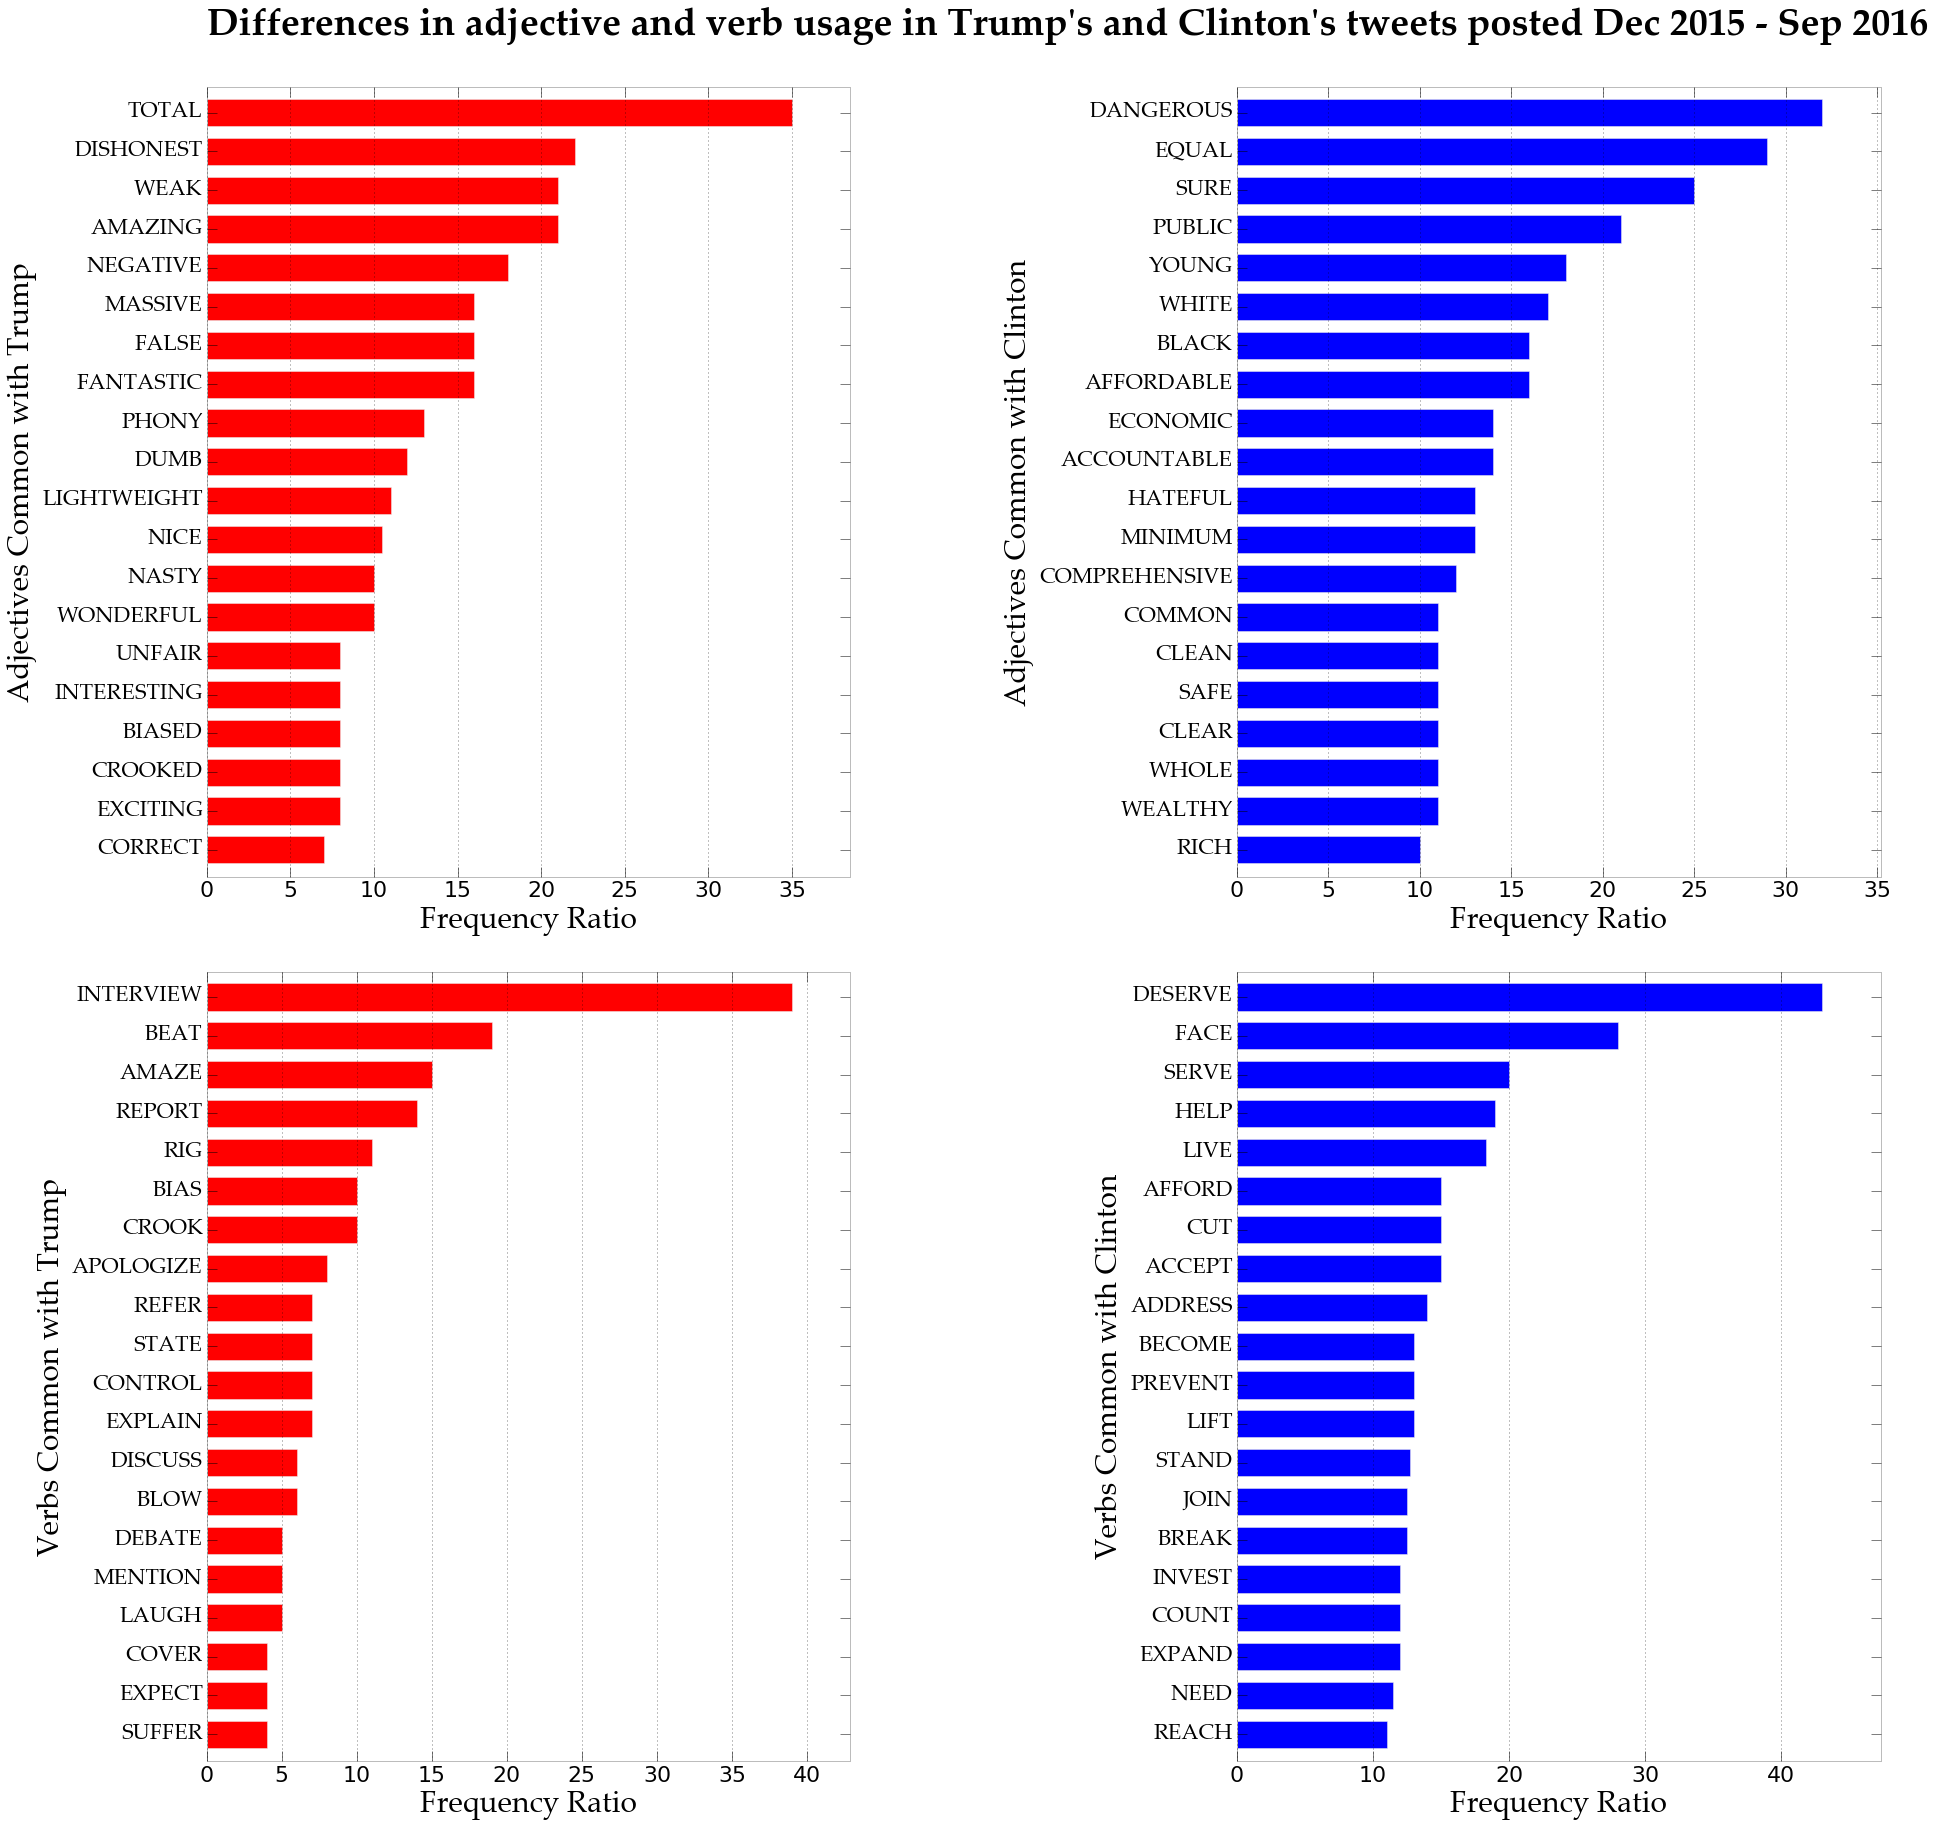

In [20]:
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'xtick.major.size': 10})
plt.rcParams.update({'ytick.major.size': 10})
pfont = {'fontname': 'Palatino Linotype'}

plt.style.use('bmh')
fig, ax = plt.subplots(2, 2, figsize=(30,30))

bar_pos = np.arange(n_top_words)
bar_width = 0.7

ax[0,0].barh(bar_pos, 
             [x[1] for x in sorted_f_adj_trump_android_clinton], 
             color='red', height=bar_width)
ax[0,0].set_yticklabels([x[0].upper() for x in sorted_f_adj_trump_android_clinton], **pfont)
ax[0,0].set_title("Differences in adjective and verb usage in Trump's and Clinton's tweets posted Dec 2015 - Sep 2016", 
                loc='left', y=1.06, fontsize=38, weight='bold', **pfont)
ax[0,0].set_ylabel('Adjectives Common with Trump', fontsize=30, **pfont)
x_max = np.max([x[1] for x in sorted_f_adj_trump_android_clinton])
ax[0,0].set_xlim([0, x_max*1.1])

ax[0,1].barh(bar_pos, 
             [x[1] for x in sorted_f_adj_clinton_trump_android], 
             color='blue', height=bar_width)
ax[0,1].set_yticklabels([x[0].upper() for x in sorted_f_adj_clinton_trump_android], **pfont)
ax[0,1].set_ylabel('Adjectives Common with Clinton', fontsize=30, **pfont)
x_max = np.max([x[1] for x in sorted_f_adj_clinton_trump_android])
ax[0,1].set_xlim([0, x_max*1.1])

ax[1,0].barh(bar_pos, 
             [x[1] for x in sorted_f_vb_trump_android_clinton], 
             color='red', height=bar_width)
ax[1,0].set_yticklabels([x[0].upper() for x in sorted_f_vb_trump_android_clinton], **pfont)
ax[1,0].set_ylabel('Verbs Common with Trump', fontsize=30, **pfont)
x_max = np.max([x[1] for x in sorted_f_vb_trump_android_clinton])
ax[1,0].set_xlim([0, x_max*1.1])

ax[1,1].barh(bar_pos, 
             [x[1] for x in sorted_f_vb_clinton_trump_android], 
             color='blue', height=bar_width)
ax[1,1].set_yticklabels([x[0].upper() for x in sorted_f_vb_clinton_trump_android], **pfont)
ax[1,1].set_ylabel('Verbs Common with Clinton', fontsize=30, **pfont)
x_max = np.max([x[1] for x in sorted_f_vb_clinton_trump_android])
ax[1,1].set_xlim([0, x_max*1.1])


for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].set_yticks([pos + bar_width/2 for pos in bar_pos])
        ax[i,j].set_ylim([-bar_width/2,n_top_words])
        ax[i,j].xaxis.grid(True)
        ax[i,j].yaxis.grid(False)
        ax[i,j].set_xlabel('Frequency Ratio', fontsize=30, **pfont)
        ax[i,j].xaxis.set_tick_params(labelsize=22)
        ax[i,j].set_axis_bgcolor('white')
        
plt.subplots_adjust(wspace=0.6, hspace=0.12)
plt.savefig(root_dir + "figs/differences_in_adj_verbs_usage.pdf")